In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme()

In [6]:
"""
The density value used for each setting is: 
     - Fresh Water = 1000kg/m³ 
     - EN13319 = 1020 kg/m³ 
     - Salt Water = 1030 kg/m³
"""

rho_water = 1030.0 # Water density [kg/m**3]
p_water_vapor = 0.0627 * 1E5 # Water vapor pressure in lungs [Pa]
p_atm_sea_level = 101325.0 # Ambiant pressure at sea level [Pa]
g = 9.81 # gravity [m*s**-2]

In [7]:
def read_M_values_from_file(file_path):
    df_M_Values = pd.read_csv(file_path, sep = ";")
    M_values = {}
    for i in range(len(df_M_Values)):
        cpt = df_M_Values.iloc[i]['Cpt']
        HT = df_M_Values.iloc[i]['Half-time [sec]']
        M0 = df_M_Values.iloc[i]['M0']
        M_slope = df_M_Values.iloc[i]['M_slope']
        M_values[cpt] = {}
        M_values[cpt]["HT"] = HT
        M_values[cpt]["M0"] = M0
        M_values[cpt]["M_Slope"] = M_slope       
    return M_values



def is_below_cpt_mvalue_line(cpt, Pamb, P):
    # P : Inert gas tissue pressure
    # Pamb : Ambiant pressure
    return P < (M_values[cpt]['M0'] + M_values[cpt]['M_Slope'] * (Pamb - p_atm_sea_level/1E5))

    
    
def shreiner(k, R, P0, Pi0, t):
    # k : half-time constant = ln2/half-time [sec**-1]
    # R : rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
    # Pi0 : initial inspired (alveolar) inert gas pressure [bar]
    # P0 : initial compartment inert gas pressure [bar]
    P = Pi0 + R * (t - (1/k)) - (Pi0 - P0 - (R/k)) * np.exp(-k*t)
    return P
    
    
    
def define_dive_depth_profile(depth, time):
    time *= 60
    descent_time = depth / des_speed
    total_diving_time = int(descent_time + time)   
    start = pd.to_datetime('00:00:00', format = "%H:%M:%S")
    times = [start + pd.Timedelta(seconds = i) for i in range(total_diving_time + 1)]
    phases = []
    depths = []
    for t in times:
        if ((t - times[0]).total_seconds() <= descent_time):
            depth = (t - times[0]).total_seconds() * des_speed
            phase = "Descent"
        else:
            depth = depth
            phase = "Bottom"
        depths.append(depth)
        phases.append(phase)
        
    output = pd.DataFrame({'Temps [sec]' : times, 'Profondeur [m]' : depths, 'Phase' : phases})
    return output



def calculate_cpt_saturation_along_dive(diving_profile):
    nb_steps = len(diving_profile)
    time_steps = list(diving_profile["Temps [sec]"])
    depth_steps = list(diving_profile["Profondeur [m]"])

    for cpt in M_values.keys():
        #print(" > Cpt ° " + cpt)
        HT = M_values[cpt]['HT']
        k = np.log(2) / HT # k = half-time constant = ln2/half-time
        tissue_time_sat = []
        for i in range(nb_steps):
            if (i == 0):
                tissue_time_sat.append(0.79 * ((p_atm_sea_level - p_water_vapor) / 1E5))
            else:
                P0 = tissue_time_sat[-1] # initial compartment inert gas pressure [bar]
                Pamb = p_atm_sea_level + depth_steps[i] * rho_water * g
                Pi0 = N2Part * ((Pamb - p_water_vapor) / 1E5) # initial inspired (alveolar) inert gas pressure [bar]
                depth_delta = depth_steps[i] - depth_steps[i-1]
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
                desc_speed = depth_delta / time_delta
                R = N2Part * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure
                t = time_delta # time
                tissue_time_sat.append(shreiner(k, R, P0, Pi0, t))
            
        diving_profile['pN2_cpt_' + cpt + ' [bar]'] = tissue_time_sat
    return diving_profile
    

    
def calculate_cpt_saturation_after_dive(diving_profile, time_after_dive_min):
    start = diving_profile['Temps [sec]'].tail(1).values[0]
    time_steps = [start + pd.Timedelta(seconds = i) for i in range(1, time_after_dive_min*60 + 1)]
    depth_steps = [0. for i in range(1, time_after_dive_min*60 + 1)]
    diving_profile_surf = pd.DataFrame()
    
    diving_profile_surf['Profondeur [m]'] = depth_steps
    diving_profile_surf['Temps [sec]'] = time_steps
    
    for cpt in M_values.keys():
        #print(" > Cpt ° " + cpt)
        HT = M_values[cpt]['HT']
        k = np.log(2) / HT # k = half-time constant = ln2/half-time
        tissue_time_sat = []
        for i in range(len(time_steps)):
            if (i == 0):
                P0 = diving_profile['pN2_cpt_' + cpt + ' [bar]'].tail(1).values[0] # initial compartment inert gas pressure [bar]
            else:
                P0 = tissue_time_sat[-1]
                
            Pamb = p_atm_sea_level + depth_steps[i] * rho_water * g
            Pi0 = 0.79 * ((Pamb - p_water_vapor) / 1E5) # initial inspired (alveolar) inert gas pressure [bar]
            depth_delta = depth_steps[i] - depth_steps[i-1]
            if (i == 0):
                time_delta = (time_steps[i] - start).total_seconds()
            else:
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
            R = 0.
            t = time_delta # time
            tissue_time_sat.append(shreiner(k, R, P0, Pi0, t))
           
        diving_profile_surf['pN2_cpt_' + cpt + ' [bar]'] = tissue_time_sat
    return diving_profile_surf
    
    
    
    
def get_ascent_duration(current_depth, final_depth, ascent_speed):
    return (final_depth - current_depth) / -ascent_speed




def get_next_deco_stop(N2Part, ascent_speed, curr_depth, pN2_cpts, idx_deco_stop = 0):      
    is_above_mvalue_line = True
    directing_cpt = None
    while (is_above_mvalue_line):
        final_depth_candidate = possible_deco_stops[idx_deco_stop]            
        t = get_ascent_duration(curr_depth, final_depth_candidate, ascent_speed)
        for cpt in M_values.keys():
            k = np.log(2) / M_values[cpt]['HT']
            R = - N2Part * ascent_speed * ((rho_water * g) / 1E5)
            Pamb = p_atm_sea_level + curr_depth * rho_water * g
            Pi0 = N2Part * ((Pamb - p_water_vapor) / 1E5)
            P0 = pN2_cpts["pN2_cpt_" + cpt + " [bar]"]
            P = shreiner(k, R, P0, Pi0, t)
            Pamb = (p_atm_sea_level + (final_depth_candidate * rho_water * g)) / 1E5                     
            if (is_below_cpt_mvalue_line(cpt, Pamb, P)):
                is_above_mvalue_line = False   
            else:
                is_above_mvalue_line = True
                directing_cpt = cpt
                break               
        if (not is_above_mvalue_line):
            return final_depth_candidate, directing_cpt       
        else:
            idx_deco_stop += 1
            
            
            
def calculate_time_at_next_deco_stop(N2Part, ascent_speed, curr_depth, deco_depth, pN2_cpts):
    ascent_time = get_ascent_duration(curr_depth, deco_depth, ascent_speed)
    pN2_cpts_after_ascent = {}
    for cpt in M_values.keys():
        k = np.log(2) / M_values[cpt]['HT']
        R = - N2Part * ascent_speed * ((rho_water * g) / 1E5)
        Pamb = p_atm_sea_level + curr_depth * rho_water * g
        Pi0 = N2Part * (Pamb - p_water_vapor) / 1E5
        P0 = pN2_cpts["pN2_cpt_" + cpt + " [bar]"]
        P = shreiner(k, R, P0, Pi0, ascent_time)
        pN2_cpts_after_ascent["pN2_cpt_" + cpt + " [bar]"] = P
        
    stay_at_depth = True
    time_at_stop_min = 1
    while (stay_at_depth):
        pN2_cpts_candidates = {}
        for cpt in M_values.keys():
            k = np.log(2) / M_values[cpt]['HT']
            Pamb = p_atm_sea_level + (deco_depth * rho_water * g)
            Pi0 = N2Part * (Pamb - p_water_vapor) / 1E5
            P0 = pN2_cpts_after_ascent["pN2_cpt_" + cpt + " [bar]"]
            P = shreiner(k, 0., P0, Pi0, time_at_stop_min * 60)
            pN2_cpts_candidates["pN2_cpt_" + cpt + " [bar]"] = P
        next_deco_depth, _ = get_next_deco_stop(N2Part, ascent_speed, deco_depth, pN2_cpts_candidates, idx_deco_stop = 0)           
        
        if (next_deco_depth > deco_depth):
            print("Problem : Diver above deco ceil !!!")
                
        elif (next_deco_depth < deco_depth):
            stay_at_depth = False
        
        elif (next_deco_depth == deco_depth):
            time_at_stop_min += 1    
    
    return (time_at_stop_min, pN2_cpts_candidates)



def calculate_deco_profile(diving_profile, ascent_speed, ascent_speed_between_stops):
    pN2_cpts = diving_profile[[c for c in diving_profile.columns if ("pN2_cpt_" in c)]].iloc[-1]
    curr_depth = diving_profile["Profondeur [m]"].iloc[-1]
    fin_depth = 0.
    deco_stops = []
    deco_stop = 1
    while (deco_stop > 0):
        if (len(deco_stops) == 0): ascent_speed = ascent_speed
        else: ascent_speed = ascent_speed_between_stops                  
        deco_stop, directing_cpt = get_next_deco_stop(N2Part, ascent_speed, curr_depth, pN2_cpts)
        if (deco_stop > 0.):
            (deco_time, pN2_cpts) = calculate_time_at_next_deco_stop(N2Part, ascent_speed, curr_depth, deco_stop, pN2_cpts)
            deco_stops.append({'DECO_DEPTH [m]' : deco_stop, 'DECO_TIME [min]' : deco_time, 'SPEED_ASCENT [m/sec]' : ascent_speed, 'DIRECTING CPT' : directing_cpt})
            curr_depth = deco_stop            
    return deco_stops



def add_deco_to_depth_profile(diving_profile, deco_profile):
    depths = diving_profile['Profondeur [m]'].tolist()
    times = diving_profile['Temps [sec]'].tolist()    
    depth = depths[-1]
    t = times[-1]  
    for deco_stop in deco_profile:
        speed_ascent = deco_stop['SPEED_ASCENT [m/sec]']
        deco_time = deco_stop['DECO_TIME [min]']
        deco_depth = deco_stop['DECO_DEPTH [m]']        
        ascent_seconds = int(np.ceil((depth - deco_depth) / speed_ascent))
        for i in range(1, ascent_seconds + 1):
            depth += - speed_ascent
            t += pd.Timedelta(seconds = 1)
            depths.append(depth)
            times.append(t)
        for j in range(1, deco_time * 60 + 1):
            t += pd.Timedelta(seconds = 1)
            depths.append(depth)
            times.append(t)
    output = pd.DataFrame()
    output['Profondeur [m]'] = depths
    output['Temps [sec]'] = times    
    return output      



def calculate_GF_lines(GF_low, GF_high, Pamb_max, M_values):
    custom_M_values = {}
    for cpt in M_values.keys():
        M0 = M_values[cpt]['M0']
        M_slope = M_values[cpt]['M_Slope']
        custom_M0 = (M0 - 1.) * GF_high + 1.    
        point_1 = np.array([Pamb_max, Pamb_max])
        point_2 = np.array([1. + (Pamb_max - M0)/(M_slope), Pamb_max])
        point_GF_low = point_1 * (1 - GF_low) + point_2 * GF_low
        custom_M_slope = (point_GF_low[1] - custom_M0) / (point_GF_low[0] - 1.)
        custom_M_values[cpt] = {}
        custom_M_values[cpt]['M0'] = custom_M0
        custom_M_values[cpt]['M_Slope'] = custom_M_slope  
        custom_M_values[cpt]['HT'] = M_values[cpt]['HT']
    return custom_M_values



def total_time_to_surface(depth, deco_profile):
    tts = 0
    for deco_stop in deco_profile:
        time_to_stop = (depth - deco_stop['DECO_DEPTH [m]']) / (60 * deco_stop['SPEED_ASCENT [m/sec]'])
        time_at_stop = deco_stop['DECO_TIME [min]']
        tts += time_to_stop + time_at_stop
        depth = deco_stop['DECO_DEPTH [m]']
    tts += deco_profile[-1]['DECO_DEPTH [m]'] / (60 * deco_profile[-1]['SPEED_ASCENT [m/sec]'])
    tts = int(np.ceil(tts))
    return tts



def get_limit_depth_for_deco_mix(O2Part_Deco, O2Part_admissible = 1.6):
    return 10 * ((O2Part_admissible / O2Part_Deco) - 1)
    
    
    
def calculate_cpt_saturation_with_deco_mix(diving_profile, O2Part_adm = 1.6):
    max_depth_deco_mix = get_limit_depth_for_deco_mix(O2Part_Deco, O2Part_admissible = O2Part_adm)
    nb_steps = len(diving_profile)
    time_steps = list(diving_profile["Temps [sec]"])
    depth_steps = list(diving_profile["Profondeur [m]"])
    
    for i in range(len(diving_profile)):
        depth = depth_steps[len(diving_profile)-i-1]    
        if (depth > max_depth_deco_mix):
            first_timestep_deco = time_steps[len(diving_profile)-i-1]
            break
        
    for cpt in M_values.keys():
        #print(" > Cpt ° " + cpt)
        HT = M_values[cpt]['HT']
        k = np.log(2) / HT # k = half-time constant = ln2/half-time
        tissue_time_sat = []
        for i in range(nb_steps):
            if (i == 0):
                tissue_time_sat.append(0.79 * ((p_atm_sea_level - p_water_vapor) / 1E5))
            else:
                P0 = tissue_time_sat[-1] # initial compartment inert gas pressure [bar]
                Pamb = p_atm_sea_level + depth_steps[i] * rho_water * g
                depth_delta = depth_steps[i] - depth_steps[i-1]
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
                desc_speed = depth_delta / time_delta
                
                if ((time_steps[i] < first_timestep_deco) and (depth_steps[i] > 0.001)):
                    Pi0 = N2Part * ((Pamb - p_water_vapor) / 1E5) # initial inspired (alveolar) inert gas pressure [bar]
                    R = N2Part * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure
                
                elif ((time_steps[i] >= first_timestep_deco) and (depth_steps[i] > 0.001)):
                    Pi0 = (1.0 - O2Part_Deco) * ((Pamb - p_water_vapor) / 1E5) # initial inspired (alveolar) inert gas pressure [bar]
                    R = (1.0 - O2Part_Deco) * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure
                
                else:
                    Pi0 = 0.79 * ((Pamb - p_water_vapor) / 1E5) # initial inspired (alveolar) inert gas pressure [bar]
                    R = 0.79 * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure

                t = time_delta # time
                tissue_time_sat.append(shreiner(k, R, P0, Pi0, t))
            
        diving_profile['pN2_cpt_' + cpt + ' [bar]_deco'] = tissue_time_sat
    return diving_profile
    

In [10]:
M_values = read_M_values_from_file("Buhlmann_Zh-L16C_M-values.csv")
M_values_basis = M_values
N2Part = 0.79 # unit : %

des_speed = 240 / 60 # unit : m/sec
asc_speed = 240 / 60 # unit : m/sec
diving_profile = define_dive_depth_profile(depth = 240, time = 0.5)

depth = diving_profile['Profondeur [m]'].values[-1]
time = diving_profile['Temps [sec]'].values[-1]
timestep = diving_profile['Temps [sec]'].values[-1] - diving_profile['Temps [sec]'].values[-2]

while (depth > 0.001):
    depth = depth - asc_speed * timestep.astype('timedelta64[s]').astype(np.int32)
    time = time + timestep
    diving_profile = diving_profile.append({'Temps [sec]' : time, 'Profondeur [m]' : depth, 'Phase' : 'Ascent'}, ignore_index = True)

diving_profile = calculate_cpt_saturation_along_dive(diving_profile)
diving_profile_post_dive = calculate_cpt_saturation_after_dive(diving_profile, time_after_dive_min = 15)
diving_profile = pd.concat([diving_profile, diving_profile_post_dive], ignore_index = True)

<ipython-input-11-1eb3828f0b9b>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, 1].set_xticklabels(diving_profile['Temps [sec]'], rotation = 30)


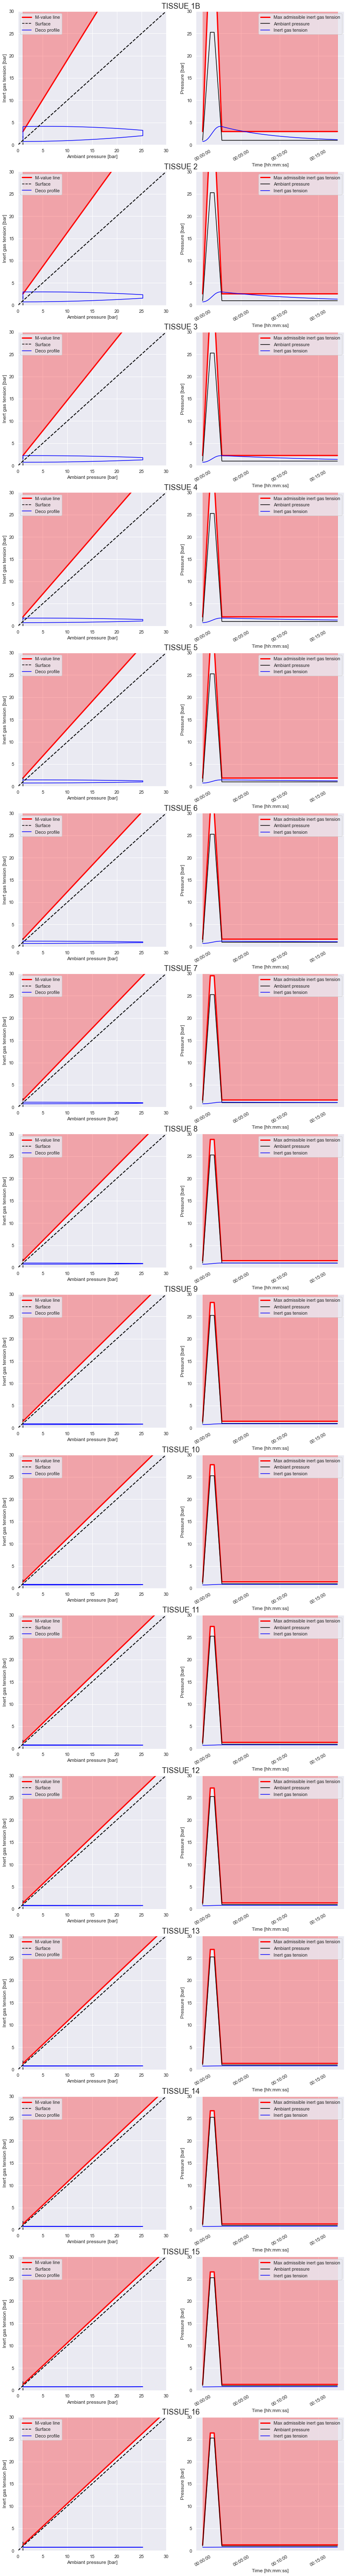

In [11]:
diving_profile['Pamb'] = (p_atm_sea_level + (diving_profile['Profondeur [m]'] * rho_water * g)) / 1E5    

cpts = list(M_values.keys())
fig, axs = plt.subplots(len(cpts), 2, figsize = (14, 7 * len(cpts)))
i = 0
for cpt in cpts:
    col_name = "pN2_cpt_" + cpt + " [bar]"
    M0 = M_values_basis[cpt]['M0']
    M_slope = M_values_basis[cpt]['M_Slope']
    x = [i for i in range(1, 100)]
    M_line = [(p - 1) * M_slope + M0 for p in x]
    axs[i, 0].plot(x, M_line, color = 'red', linewidth = 3, label = "M-value line")
    axs[i, 0].plot([1., 1.], [0., 2.], linestyle = '--', color = 'black', label = "Surface")
    axs[i, 0].plot(diving_profile['Pamb'], diving_profile[col_name], color = 'blue', label = "Deco profile")
    axs[i, 0].set_xlabel('Ambiant pressure [bar]')
    axs[i, 0].set_ylabel('Inert gas tension [bar]')
    axs[i, 0].set_xlim([0., 30.])
    axs[i, 0].set_ylim([0., 30.])
    axs[i, 0].plot([0., 100.], [0., 100.], color = 'black', linestyle = '--', linewidth = 2)
    axs[i, 0].fill_between(x, M_line, 100., color = 'red', alpha = 0.3)
    axs[i, 0].set_title("TISSUE " + cpt.upper(), fontsize = 18)
    ttl = axs[i, 0].title
    ttl.set_position([1.1, 1.2])
    axs[i, 0].legend()
    
    Pamb_max = diving_profile['Pamb'].max()
       
    M_val_lim = (diving_profile['Pamb'] - 1.) * M_slope + M0
    axs[i, 1].plot(diving_profile['Temps [sec]'], M_val_lim, color = 'red', linewidth = 3, label = "Max admissible inert gas tension")
    axs[i, 1].plot(diving_profile['Temps [sec]'], diving_profile['Pamb'], color = 'black', label = "Ambiant pressure")
    axs[i, 1].plot(diving_profile['Temps [sec]'], diving_profile[col_name], color = 'blue', label = "Inert gas tension")
    axs[i, 1].set_xticklabels(diving_profile['Temps [sec]'], rotation = 30)
    axs[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    axs[i, 1].fill_between(diving_profile['Temps [sec]'], M_val_lim, 100., color = 'red', alpha = 0.3)
    axs[i, 1].set_xlabel('Time [hh:mm:ss]')
    axs[i, 1].set_ylabel('Pressure [bar]')
    axs[i, 1].set_ylim([0., 30.])
    axs[i, 1].legend()   
    i += 1

plt.savefig("saturation_profile_240m.pdf")